**Mounting** **Drive** 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Importing Libraries**

In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)


In [ ]:
data_dir = '/content/gdrive/MyDrive/envirya_YOLO/data/annotate'

**Counting Images and Annotations file**

In [ ]:
jpg_files = [i for i in os.listdir('/content/gdrive/MyDrive/envirya_YOLO/data/Orig_Image') if i.endswith('jpg')]
xml_files = [i for i in os.listdir(data_dir) if i.endswith('xml')]
#png_files = [i for i in os.listdir(data_dir) if i.endswith('png')]

print("Number of .jpg files : ", len(jpg_files))
print("Number of .xml files : ", len(xml_files))
#print(len(png_files))

Number of .jpg files :  479
Number of .xml files :  479


**Extracting data from Annotations file**

In [ ]:
# Function to get the data from XML Annotation

import xml.etree.ElementTree as ET
import os
import glob


def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
print(extract_info_from_xml('/content/gdrive/MyDrive/envirya_YOLO/data/annotate/10.1.1.1.2006_3.xml'))

{'bboxes': [{'class': 'table', 'xmin': 453, 'ymin': 711, 'xmax': 680, 'ymax': 784}], 'filename': '10.1.1.1.2006_3.jpg', 'image_size': (793, 1123, 3)}


In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"table": 0}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("/content/gdrive/MyDrive/envirya_YOLO/data/annotate", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('/content/gdrive/MyDrive/envirya_YOLO/data/annotate', x) for x in os.listdir('/content/gdrive/MyDrive/envirya_YOLO/data/annotate') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('/content/gdrive/MyDrive/envirya_YOLO/data/annotate', x) for x in os.listdir('/content/gdrive/MyDrive/envirya_YOLO/data/annotate') if x[-3:] == "txt"]

In [ ]:
annotations = [os.path.join('/content/gdrive/MyDrive/envirya_YOLO/data/annotate', x) for x in os.listdir('/content/gdrive/MyDrive/envirya_YOLO/data/annotate') if x[-3:] == "txt"]

**Testing conversion of annotations**


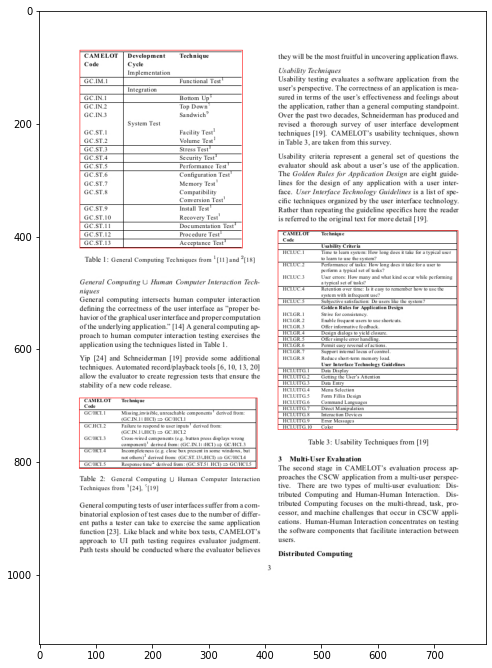

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)),outline ="red")
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt_1 = plt.figure(figsize=(8, 12))
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotate", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


**Splitting Training and Test dataset**

In [ ]:
# Read images and annotations
images = [os.path.join('/content/gdrive/MyDrive/envirya_YOLO/data/images', x) for x in os.listdir('/content/gdrive/MyDrive/envirya_YOLO/data/images')]
annotations = [os.path.join('/content/gdrive/MyDrive/envirya_YOLO/data/annotate', x) for x in os.listdir('/content/gdrive/MyDrive/envirya_YOLO/data/annotate') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


In [ ]:
!mkdir /content/gdrive/MyDrive/envirya_YOLO/data/images/train 
!mkdir /content/gdrive/MyDrive/envirya_YOLO/data/images/val 
!mkdir /content/gdrive/MyDrive/envirya_YOLO/data/images/test 
!mkdir /content/gdrive/MyDrive/envirya_YOLO/data/annotate/train 
!mkdir /content/gdrive/MyDrive/envirya_YOLO/data/annotate/val 
!mkdir /content/gdrive/MyDrive/envirya_YOLO/data/annotate/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/content/gdrive/MyDrive/envirya_YOLO/data/images/train/')
move_files_to_folder(val_images, '/content/gdrive/MyDrive/envirya_YOLO/data/images/val/')
move_files_to_folder(test_images, '/content/gdrive/MyDrive/envirya_YOLO/data/images/test/')
move_files_to_folder(train_annotations, '/content/gdrive/MyDrive/envirya_YOLO/data/annotate/train/')
move_files_to_folder(val_annotations, '/content/gdrive/MyDrive/envirya_YOLO/data/annotate/val/')
move_files_to_folder(test_annotations, '/content/gdrive/MyDrive/envirya_YOLO/data/annotate/test/')

In [ ]:
!mv /content/gdrive/MyDrive/envirya_YOLO/data/annotate /content/gdrive/MyDrive/envirya_YOLO/data/labels


In [ ]:
%cd /content/gdrive/MyDrive/envirya_YOLO/yolov5

/content/gdrive/MyDrive/envirya_YOLO/yolov5


**Training YoloV5 on Table dataset for 100 Epochs**




In [ ]:
!python train.py --img 640 --cfg /content/gdrive/MyDrive/envirya_YOLO/yolov5/models/yolov5s.yaml --hyp /content/gdrive/MyDrive/envirya_YOLO/yolov5/data/hyps/hyp.scratch.yaml --batch 32 --epochs 100 --data /content/gdrive/MyDrive/envirya_YOLO/yolov5/data/table_detect.yaml --workers 24 --name yolo_table_det

train: weights=yolov5s.pt, cfg=/content/gdrive/MyDrive/envirya_YOLO/yolov5/models/yolov5s.yaml, data=/content/gdrive/MyDrive/envirya_YOLO/yolov5/data/table_detect.yaml, hyp=/content/gdrive/MyDrive/envirya_YOLO/yolov5/data/hyps/hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, entity=None, name=yolo_table_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 2021-7-21 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5,

**Detecting on Test Images**

In [ ]:
!python detect.py --source /content/gdrive/MyDrive/envirya_YOLO/data/images/test/10.1.1.1.2034_11.jpg --weights runs/train/yolo_table_det2/weights/best.pt --conf 0.25 --name yolo_table_det2

detect: weights=['runs/train/yolo_table_det2/weights/best.pt'], source=/content/gdrive/MyDrive/envirya_YOLO/data/images/test/, imgsz=640, conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_table_det2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-303-g3bef77f torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layer

In [ ]:
!python detect.py --source /content/gdrive/MyDrive/envirya_YOLO/yolov5/runs/detect/yolo_table_det2/10.1.1.1.2018_8.jpg --weights runs/train/yolo_table_det2/weights/best.pt --conf 0.25 --name yolo_table_det2 --view-img --save-crop

detect: weights=['runs/train/yolo_table_det2/weights/best.pt'], source=/content/gdrive/MyDrive/envirya_YOLO/yolov5/runs/detect/yolo_table_det2/10.1.1.1.2018_8.jpg, imgsz=640, conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=True, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_table_det2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-303-g3bef77f torch 1.9.0+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_

**Converting cropped table image to csv text**

In [ ]:
def final(img_path, output_dir='temp_output', show_table=False):
    tab = Image.open(img_path)
    text = pytesseract.image_to_string(tab,lang='eng', config='-psm 1')
    text = text.strip()
    text = re.sub("[\r\n]+", "\r\n", text)
    csv = text2csv(text)
    csv_fname = img_path.split(os.path.sep)[-1].replace('jpg', 'csv')
    dest_dir = os.path.join(output_dir)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    dest = os.path.join(dest_dir, csv_fname)
    # if file already exists in the temp directory it will save the csv 
    # by appending some offset to the filename before extension
    try:
        os.rename(csv, dest)
    except:
        f_save = 'fail'
        i=2
        while(f_save=='fail'):
            name_off = str(i)
            try:
                dest = os.path.join(dest_dir, append_offset(csv_fname,name_off))
                os.rename(csv, dest)
                f_save = 'pass'
            except:
                i += 1

    if show_table:
        visualize(tab)

    return dest


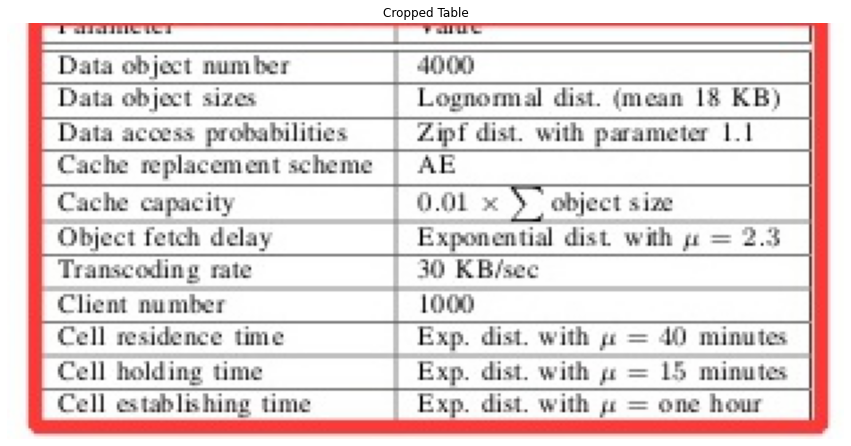

'/content/gdrive/MyDrive/envirya_YOLO/yolov5/temp_output/10.1.1.1.2018_8.csv'

In [ ]:
final('/content/gdrive/MyDrive/envirya_YOLO/yolov5/runs/detect/yolo_table_det24/crops/table/10.1.1.1.2018_8.jpg', '/content/gdrive/MyDrive/envirya_YOLO/yolov5/temp_output', True)

In [ ]:
def ocr_tesseract(filename):
    text = pytesseract.image_to_string(Image.open(filename))  
    return text



In [ ]:
filename = '/content/gdrive/MyDrive/envirya_YOLO/yolov5/runs/detect/yolo_table_det23/crops/table/10.1.1.1.2034_11.jpg'
print(ocr_tesseract(filename))

Requests/ | # Front
Second | Ends

Element that
saturated

distillers

 

48-72

‘distillers
distillers

 

7-87

FE Bihemet

 

8891
92-112

‘distillers

distillers

 

13-135

136-159

 

 

distillers & FE
Ethernet

sisters

 



**References**

*   [TableNet: Deep Learning model for end-to-end Table detection and Tabular data extraction from Scanned Document Images](https://arxiv.org/abs/2001.01469)

*   [https://blog.paperspace.com/train-yolov5-custom-data/
](https://blog.paperspace.com/train-yolov5-custom-data/
)

*   [https://medium.com/analytics-vidhya/deep-learning-model-for-end-to-end-table-detection-and-tabular-data-extraction-from-scanned-3eec3dce354c](https://medium.com/analytics-vidhya/deep-learning-model-for-end-to-end-table-detection-and-tabular-data-extraction-from-scanned-3eec3dce354c)
*  [https://github.com/ultralytics/yolov5](https://github.com/ultralytics/yolov5)
*  [https://medium.com/analytics-vidhya/table-extraction-using-deep-learning-3c91790aa200](https://medium.com/analytics-vidhya/table-extraction-using-deep-learning-3c91790aa200)
   




